In [1]:
import numpy as np
import matplotlib.pyplot as plt
from regions import Regions
import regions
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from spectral_cube import SpectralCube
from astropy.table import Table

from smart_plotters.jwst_plots import JWSTCatalog, make_cat_use, make_brick_cat
from smart_plotters.cutout_plot import get_cutout_405, get_cutout_jwst_ice, Cutout
from smart_plotters import outflow_plots as op

In [2]:
coord = SkyCoord('17:46:21.3783484075', '-28:35:40.1619795493', unit=(u.hourangle, u.deg), frame='icrs')
reg = regions.RectangleSkyRegion(center=coord, width=4.0*u.arcsec, height=4.0*u.arcsec, angle=0*u.deg)

coord1 = SkyCoord('17:46:21.3587289660', '-28:35:40.8156882060', unit=(u.hourangle, u.deg), frame='icrs')
r1 = 0.3 * u.arcsec
coord2 = SkyCoord('17:46:21.3898878766', '-28:35:39.4930752128', unit=(u.hourangle, u.deg), frame='icrs')
r2 = 0.2 * u.arcsec

In [3]:
coord_empty = SkyCoord('17:46:16.3925019881', '-28:34:02.5373289603', unit=(u.hourangle, u.deg), frame='icrs')
reg_empty = regions.RectangleSkyRegion(center=coord_empty, width=10.0*u.arcsec, height=10.0*u.arcsec, angle=0*u.deg)

In [44]:
cont_fn = '/orange/adamginsburg/cmz/dustridge/cloudc/alma/reimage/uid___A002_Xfbf8a1_Xfe1/uid___A001_X1590_X282a.CloudC_sci.spw25_27_29_31.cont.selfcal.I.tt0.pbcor.fits'
cont_cutout = Cutout(position=coord, l=4.0*u.arcsec, w=4.0*u.arcsec)
cont_cutout = cont_cutout.get_cutout(cont_fn)
jwst_cutout, jwst_cutout_ww = get_cutout_jwst_ice(coord, 4*u.arcsec, 4*u.arcsec)
cont_hdu = fits.open(cont_fn)[0]
#cont_wcs = WCS(cont_hdu.header)
#cont_data = cont_hdu.data

In [5]:
fn_cube_CO = '/orange/adamginsburg/cmz/dustridge/cloudc/alma/reimage/uid___A002_Xfbf8a1_Xfe1/uid___A001_X1590_X282a.CloudC_sci.spw29.cube.selfcal.I.pbcor.fits'
cube_CO = SpectralCube.read(fn_cube_CO)
specax = cube_CO.spectral_axis
speccube = cube_CO
cube_CO = cube_CO.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=230.538 * u.GHz)
subcube = speccube.subcube_from_regions([reg])

5.443829286377877e-05 Jy / beam


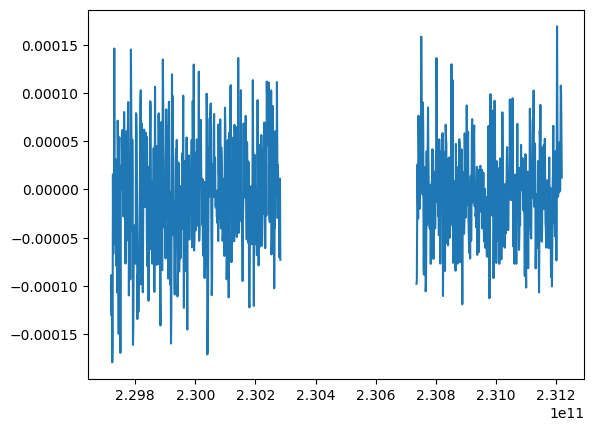

In [6]:
cube_empty = speccube.subcube_from_regions([reg_empty])
spec_empty = cube_empty.mean(axis=(1,2))
spec_empty[500:900] = np.nan
std_empty = np.nanstd(spec_empty)
plt.plot(cube_empty.spectral_axis, spec_empty)
print(std_empty)

In [7]:
subcube1 = speccube.subcube_from_regions([regions.CircleSkyRegion(center=coord1, radius=r1)])
subcube2 = speccube.subcube_from_regions([regions.CircleSkyRegion(center=coord2, radius=r2)])

In [8]:
spec1 = subcube1.mean(axis=(1,2))
spec2 = subcube2.mean(axis=(1,2))

spec1_masked = spec1.copy() #spec1[spec1 > 5*std_empty]
spec1_masked[spec1_masked < 5*std_empty] = np.nan
spec2_masked = spec2.copy() #spec2[spec2 > 5*std_empty]
spec2_masked[spec2_masked < 5*std_empty] = np.nan

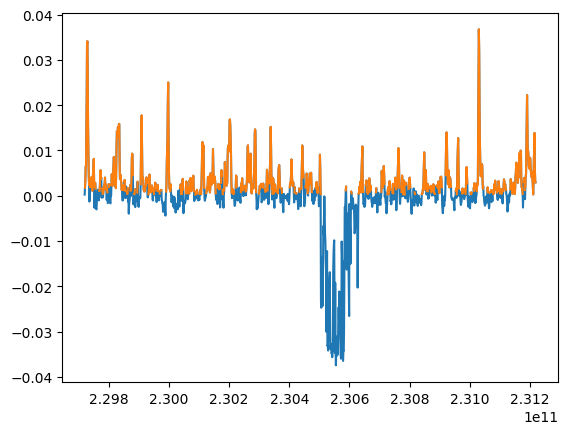

In [9]:
plt.plot(spec1.spectral_axis, spec1.value, label='Core 1')
plt.plot(spec1_masked.spectral_axis, spec1_masked.value, label='Core 1 (masked)')

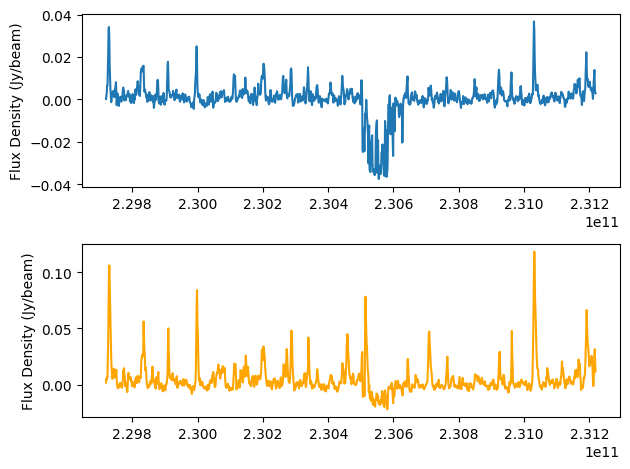

In [10]:
ax = plt.subplot(211)
ax.plot(spec1.spectral_axis, spec1.value, label='Core 1')

ax.set_ylabel('Flux Density (Jy/beam)')
ax = plt.subplot(212)
ax.plot(spec2.spectral_axis, spec2.value, label='Core 2', color='orange')
ax.set_ylabel('Flux Density (Jy/beam)')
#ax.set_xlabel('Velocity (km/s)')
plt.tight_layout()
plt.show()

In [11]:
#from astroquery.splatalogue import Splatalogue
#
#linelist = Splatalogue.query_lines(np.min(specax).to(u.GHz),
#                        np.max(specax).to(u.GHz), #only_astronomically_observed=True,
#                        line_lists=['JPL', 'CDMS'], line_strengths=['Aij'], energy_levels=['Two', 'Four'],
#                        energy_max=100, energy_type='eu_k', only_NRAO_recommended=True)
#
## remove rows with repeated orderedfreq
#unique_freqs, unique_indices = np.unique(linelist['orderedfreq'], return_index=True)
#linelist_unique = linelist[unique_indices]
#
## remove rows with line strengths less than -5
##linelist_filtered = linelist_unique[linelist_unique['aij'] > -5]

In [12]:
#linelist_unique

In [13]:
np.min(specax).to(u.GHz)

<Quantity 229.71954023 GHz>

In [14]:
from astroquery.splatalogue import Splatalogue

lines =  Splatalogue.query_lines(np.min(specax).to(u.GHz), np.max(specax).to(u.GHz), only_astronomically_observed=True,
                                 chemical_name='CH3OH')
lines

species_id,name,chemical_name,resolved_QNs,linelist,LovasASTIntensity,lower_state_energy,upper_state_energy,sijmu2,sij,aij,intintensity,Lovas_NRAO,orderedfreq,lower_state_energy_K,upper_state_energy_K,orderedFreq,measFreq,upperStateDegen,moleculeTag,qnCode,labref_Lovas_NIST,rel_int_HFS_Lovas,unres_quantum_numbers,lineid,transition_in_space,transition_in_G358,obsref_Lovas_NIST,source_Lovas_NIST,telescope_Lovas_NIST,transitionBandColor,searchErrorMessage,sqlquery,requestnumber
int64,str61,str8,str20,str5,str4,float64,float64,float64,float64,float64,str1,int64,float64,float64,float64,str68,str39,str1,int64,int64,str5,str1,str20,int64,int64,int64,str5,str8,str13,str20,str1,object,int64
55,"CH<sub>3</sub>OH <font color=""red"">v<sub>t</sub> = 0-2</font>",Methanol,"8(-1,8)-7(0,7)",Lovas,10.6,0.0,0.0,0.0,0.0,0.0,,0,229758.811,0.0,0.0,"229.758811 (0.015), <span style = 'color: #DC143C'>229.758811</span>",<span style = 'color: #DC143C'></span>,,0,0,Xu_97,,"8(-1,8)-7(0,7) E",3733780,0,0,Sut85,OriMC-1,OVRO 10.4m,datatablelightpurple,,None,0
55,"CH<sub>3</sub>OH <font color=""red"">v<sub>t</sub> = 0-2</font>",Methanol,"19(5,15)-20(4,16) ++",Lovas,0.4,0.0,0.0,0.0,0.0,0.0,,0,229864.221,0.0,0.0,"229.864221 (0.046), <span style = 'color: #DC143C'>229.864221</span>",<span style = 'color: #DC143C'></span>,,0,0,Xu_97,,"19(5,15)-20(4,16) A+",3733779,0,0,Sut85,OriMC-1,OVRO 10.4m,datatablelightpurple,,None,0
55,"CH<sub>3</sub>OH <font color=""red"">v<sub>t</sub> = 0-2</font>",Methanol,"19(5,14)-20(4,17) --",Lovas,0.5,0.0,0.0,0.0,0.0,0.0,,0,229939.18,0.0,0.0,"229.93918 (0.046), <span style = 'color: #DC143C'>229.93918</span>",<span style = 'color: #DC143C'></span>,,0,0,Xu_97,,"19(5,14)-20(4,17) A-",3733778,0,0,Sut85,OriMC-1,OVRO 10.4m,datatablelightpurple,,None,0
55,"CH<sub>3</sub>OH <font color=""red"">v<sub>t</sub> = 0-2</font>",Methanol,"3(-2,2)-4(-1,4)",Lovas,5.1,0.0,0.0,0.0,0.0,0.0,,0,230027.002,0.0,0.0,"230.027002 (0.013), <span style = 'color: #DC143C'>230.027002</span>",<span style = 'color: #DC143C'></span>,,0,0,Xu_97,,"3(-2,2)-4(-1,4) E",3733777,0,0,Sut85,OriMC-1,OVRO 10.4m,datatablelightpurple,,None,0
55,"CH<sub>3</sub>OH <font color=""red"">v<sub>t</sub> = 0-2</font>",Methanol,"22(4,18)-21(5,17)",Lovas,0.2,0.0,0.0,0.0,0.0,0.0,,0,230368.199,0.0,0.0,"230.368199 (0.089), <span style = 'color: #DC143C'>230.368199</span>",<span style = 'color: #DC143C'></span>,,0,0,Xu_97,,"22(4,18)-21(5,17) E",3733776,0,0,Sut85,OriMC-1,OVRO 10.4m,datatablelightpurple,,None,0


In [15]:
linelist_fn = '/orange/adamginsburg/jwst/cloudc/dustridge-cd/data/linelist.txt'
linelist = Table.read(linelist_fn, format='ascii', delimiter=',')
linelist

species,QNs,name,Freq (GHz),aij (log)
str5,str11,str18,float64,str8
CO,2-1,Carbon Monoxide,230.538,-6.1605
OCS,19-18,Carbonyl Sulfide,231.0609934,-4.44633
13CS,5-4,Carbon Monosulfide,231.2206852,-3.60083
CH3OH,8(18)-7(07),Methanol,229.758811,-
CH3OH,3(21)-4(14),Methanol,230.027002,-


In [16]:
cube_OCS = speccube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=231.0609934*u.GHz)
subcube_OCS = cube_OCS.spectral_slab(0*u.km/u.s, 80*u.km/u.s)
subcube_OCS = subcube_OCS.subcube_from_regions([regions.CircleSkyRegion(center=coord1, radius=r1)])
spec_OCS = subcube_OCS.mean(axis=(1,2))

cube_13CS = speccube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=231.2206852*u.GHz)
subcube_13CS = cube_13CS.spectral_slab(0*u.km/u.s, 80*u.km/u.s)
subcube_13CS = subcube_13CS.subcube_from_regions([regions.CircleSkyRegion(center=coord1, radius=r1)])
spec_13CS = subcube_13CS.mean(axis=(1,2))

cube_CH3OH_818_707 = speccube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=229.758811*u.GHz)
subcube_CH3OH_818_707 = cube_CH3OH_818_707.spectral_slab(0*u.km/u.s, 80*u.km/u.s)
subcube_CH3OH_818_707 = subcube_CH3OH_818_707.subcube_from_regions([regions.CircleSkyRegion(center=coord1, radius=r1)])
spec_CH3OH_818_707 = subcube_CH3OH_818_707.mean(axis=(1,2))

cube_CH3OH_321_414 = speccube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=230.027002*u.GHz)
subcube_CH3OH_321_414 = cube_CH3OH_321_414.spectral_slab(0*u.km/u.s, 80*u.km/u.s)
subcube_CH3OH_321_414 = subcube_CH3OH_321_414.subcube_from_regions([regions.CircleSkyRegion(center=coord1, radius=r1)])
spec_CH3OH_321_414 = subcube_CH3OH_321_414.mean(axis=(1,2))

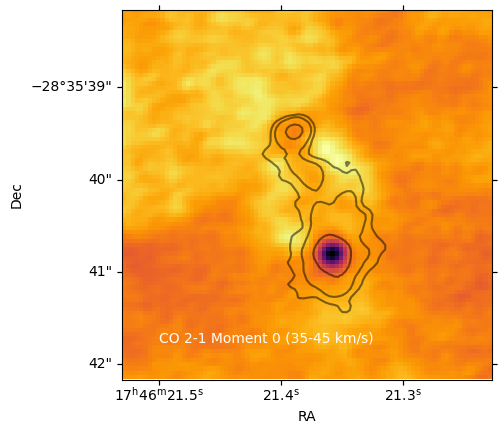

In [17]:
subcube_CO = subcube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=230.538 * u.GHz)
subcube_CO = subcube_CO.spectral_slab(35*u.km/u.s, 45*u.km/u.s)
mom0_CO = subcube_CO.moment0()

ax = plt.subplot(111, projection=mom0_CO.wcs.celestial)
ax.imshow(mom0_CO.value, origin='lower', cmap='inferno')
ax.contour(cont_cutout.data, levels=np.nanpercentile(cont_cutout.data, [91, 95, 99]), colors='k', alpha=0.5, transform=ax.get_transform(cont_cutout.wcs.celestial))
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.text(0.1, 0.1, 'CO 2-1 Moment 0 (35-45 km/s)', transform=ax.transAxes, color='white')
plt.show()

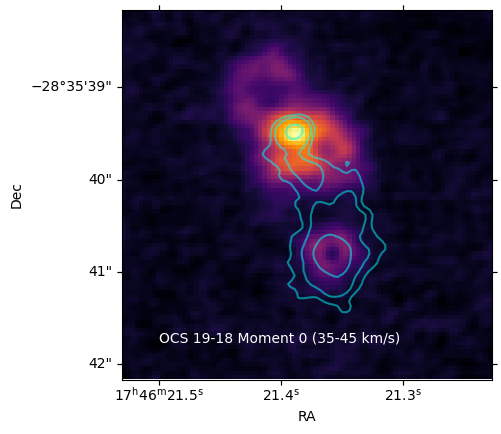

In [ ]:
subcube_OCS = subcube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=231.0609934*u.GHz)
subcube_OCS = subcube_OCS.spectral_slab(35*u.km/u.s, 45*u.km/u.s)
mom0_OCS = subcube_OCS.moment0()

ax = plt.subplot(111, projection=mom0_OCS.wcs.celestial)
ax.imshow(mom0_OCS.value, origin='lower', cmap='inferno')
ax.contour(cont_cutout.data, levels=np.nanpercentile(cont_cutout.data, [91, 95, 99]), colors='cyan', alpha=0.5, transform=ax.get_transform(cont_cutout.wcs.celestial))
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.text(0.1, 0.1, 'OCS 19-18 Moment 0 (35-45 km/s)', transform=ax.transAxes, color='white')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1672333732771142..2.1378043660971637].


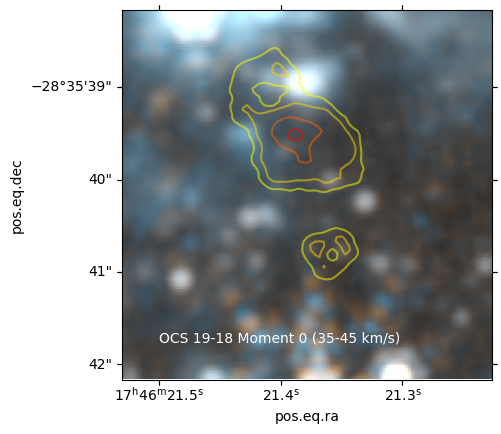

In [39]:
#jwst_cutout

ax = plt.subplot(111, projection=jwst_cutout_ww)
ax.imshow(jwst_cutout)
ax.contour(mom0_OCS.value, levels=np.nanpercentile(mom0_OCS.value, [90, 95, 99, 99.9]), cmap='autumn_r', alpha=0.5, transform=ax.get_transform(mom0_OCS.wcs.celestial))
ax.text(0.1, 0.1, 'OCS 19-18 Moment 0 (35-45 km/s)', transform=ax.transAxes, color='white')
plt.show()


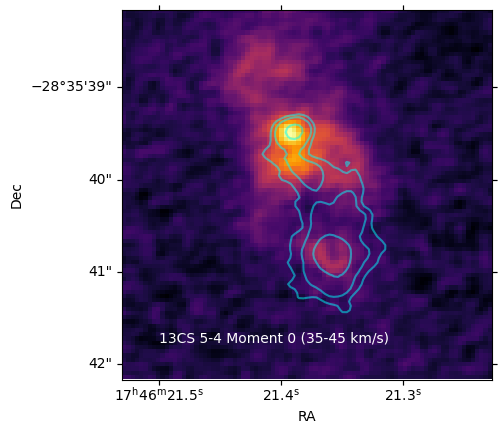

In [19]:
subcube_13CS = subcube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=231.2206852*u.GHz)
subcube_13CS = subcube_13CS.spectral_slab(35*u.km/u.s, 45*u.km/u.s)
mom0_13CS = subcube_13CS.moment0()

ax = plt.subplot(111, projection=mom0_13CS.wcs.celestial)
ax.imshow(mom0_13CS.value, origin='lower', cmap='inferno')
ax.contour(cont_cutout.data, levels=np.nanpercentile(cont_cutout.data, [91, 95, 99]), colors='cyan', alpha=0.5, transform=ax.get_transform(cont_cutout.wcs.celestial))
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.text(0.1, 0.1, '13CS 5-4 Moment 0 (35-45 km/s)', transform=ax.transAxes, color='white')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1672333732771142..2.1378043660971637].


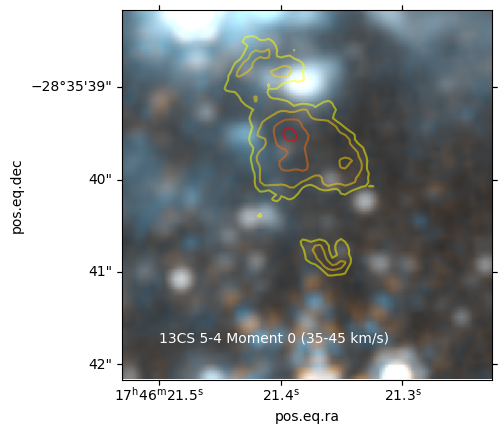

In [35]:
#jwst_cutout

ax = plt.subplot(111, projection=jwst_cutout_ww)
ax.imshow(jwst_cutout)
ax.contour(mom0_13CS.value, levels=np.nanpercentile(mom0_13CS.value, [90, 95, 99, 99.9]), cmap='autumn_r', alpha=0.5, transform=ax.get_transform(mom0_13CS.wcs.celestial))
ax.text(0.1, 0.1, '13CS 5-4 Moment 0 (35-45 km/s)', transform=ax.transAxes, color='white')
plt.show()


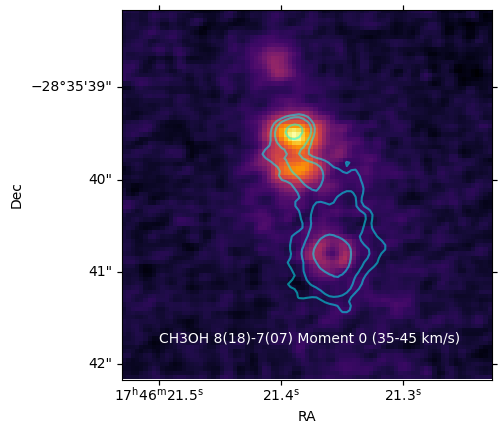

In [20]:
subcube_CH3OH_818_707 = subcube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=229.758811*u.GHz)
subcube_CH3OH_818_707 = subcube_CH3OH_818_707.spectral_slab(35*u.km/u.s, 45*u.km/u.s)
mom0_CH3OH_818_707 = subcube_CH3OH_818_707.moment0()

ax = plt.subplot(111, projection=mom0_CH3OH_818_707.wcs.celestial)
ax.imshow(mom0_CH3OH_818_707.value, origin='lower', cmap='inferno')
ax.contour(cont_cutout.data, levels=np.nanpercentile(cont_cutout.data, [91, 95, 99]), colors='cyan', alpha=0.5, transform=ax.get_transform(cont_cutout.wcs.celestial))
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.text(0.1, 0.1, 'CH3OH 8(18)-7(07) Moment 0 (35-45 km/s)', transform=ax.transAxes, color='white')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1672333732771142..2.1378043660971637].


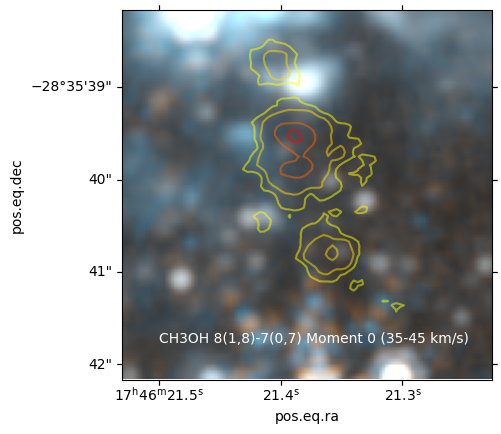

In [36]:
#jwst_cutout

ax = plt.subplot(111, projection=jwst_cutout_ww)
ax.imshow(jwst_cutout)
ax.contour(mom0_CH3OH_818_707.value, levels=np.nanpercentile(mom0_CH3OH_818_707.value, [90, 95, 99, 99.9]), cmap='autumn_r', alpha=0.5, transform=ax.get_transform(mom0_CH3OH_818_707.wcs.celestial))
ax.text(0.1, 0.1, 'CH3OH 8(1,8)-7(0,7) Moment 0 (35-45 km/s)', transform=ax.transAxes, color='white')
plt.show()


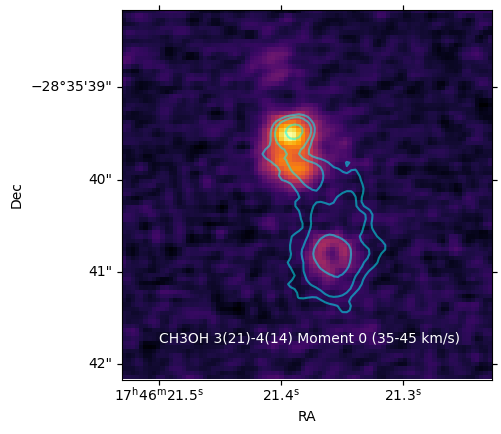

In [21]:
subcube_CH3OH_321_414 = subcube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=230.027002*u.GHz)
subcube_CH3OH_321_414 = subcube_CH3OH_321_414.spectral_slab(35*u.km/u.s, 45*u.km/u.s)
mom0_CH3OH_321_414 = subcube_CH3OH_321_414.moment0()

ax = plt.subplot(111, projection=mom0_CH3OH_321_414.wcs.celestial)
ax.imshow(mom0_CH3OH_321_414.value, origin='lower', cmap='inferno')
ax.contour(cont_cutout.data, levels=np.nanpercentile(cont_cutout.data, [91, 95, 99]), colors='cyan', alpha=0.5, transform=ax.get_transform(cont_cutout.wcs.celestial))
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.text(0.1, 0.1, 'CH3OH 3(21)-4(14) Moment 0 (35-45 km/s)', transform=ax.transAxes, color='white')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1672333732771142..2.1378043660971637].


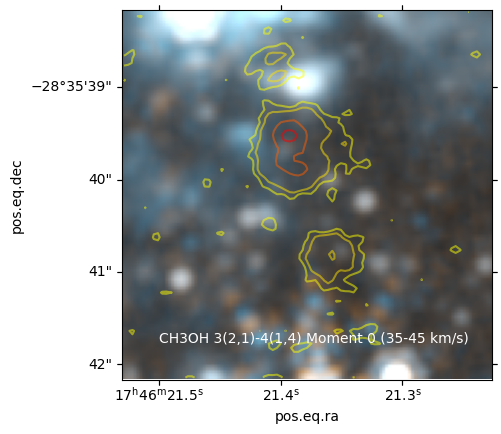

In [37]:
#jwst_cutout

ax = plt.subplot(111, projection=jwst_cutout_ww)
ax.imshow(jwst_cutout)
ax.contour(mom0_CH3OH_321_414.value, levels=np.nanpercentile(mom0_CH3OH_321_414.value, [90, 95, 99, 99.9]), cmap='autumn_r', alpha=0.5, transform=ax.get_transform(mom0_CH3OH_321_414.wcs.celestial))
ax.text(0.1, 0.1, 'CH3OH 3(2,1)-4(1,4) Moment 0 (35-45 km/s)', transform=ax.transAxes, color='white')
plt.show()


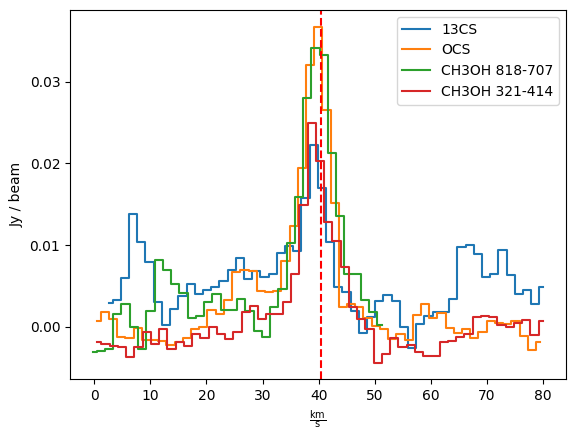

In [22]:
spec_13CS.quicklook(label='13CS')
spec_OCS.quicklook(label='OCS')
spec_CH3OH_818_707.quicklook(label='CH3OH 818-707')
spec_CH3OH_321_414.quicklook(label='CH3OH 321-414')
plt.axvline(40.5, color='red', linestyle='--')
plt.legend()

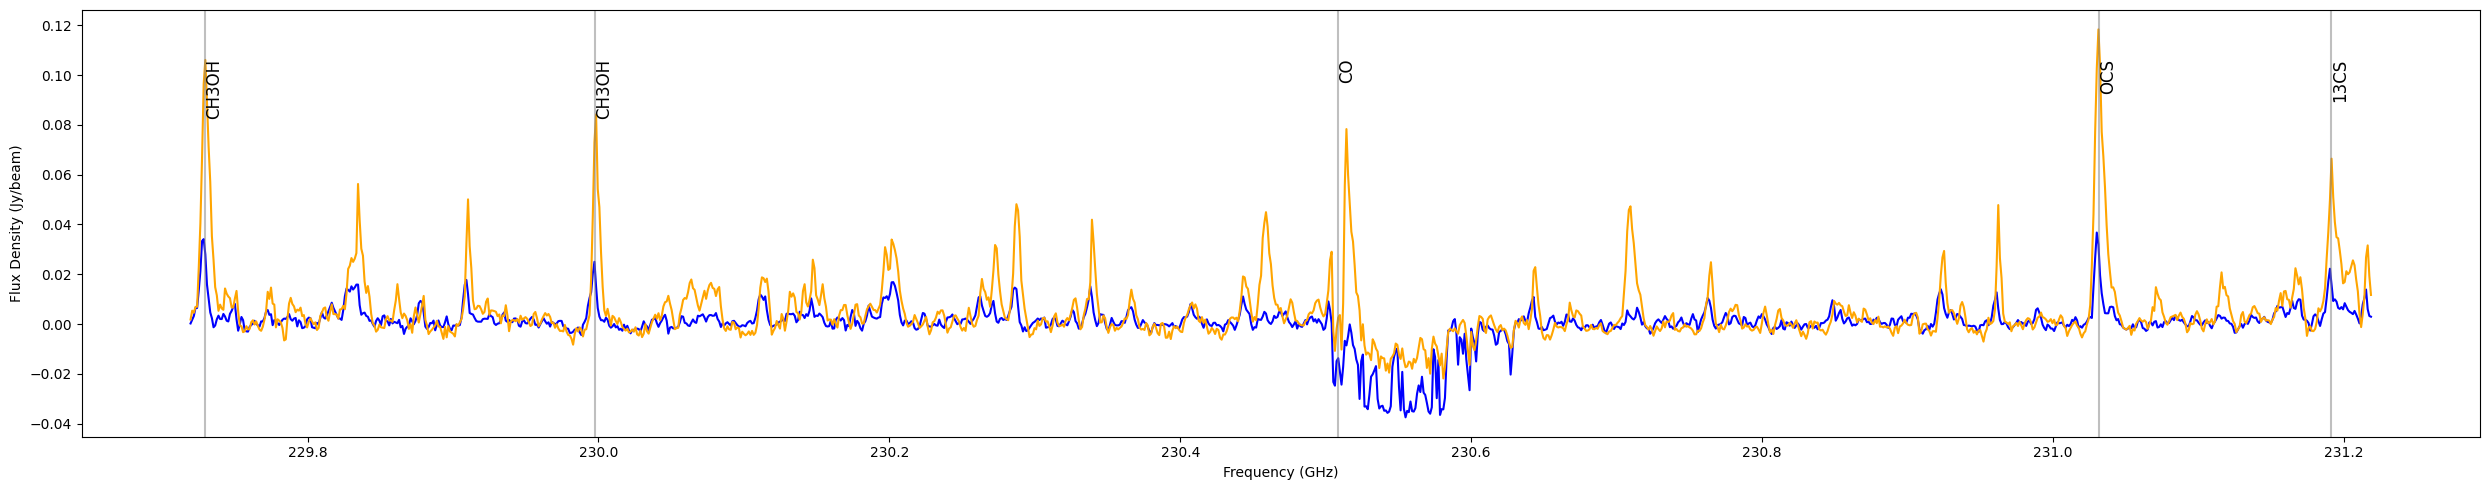

In [43]:
fig = plt.figure(figsize=(25,5))
ax = plt.subplot(111)
ax.plot(spec1.spectral_axis.to(u.GHz), spec1.value, label='Core 1', color='blue')
ax.plot(spec2.spectral_axis.to(u.GHz), spec2.value, label='Core 2', color='orange')
ax.set_ylabel('Flux Density (Jy/beam)')
ax.set_xlabel('Frequency (GHz)')

for line in linelist:
    line_freq = line['Freq (GHz)']*u.GHz
    doppler_shift = 38*u.km/u.s
    line_freq = line_freq * (1 - doppler_shift/const.c) # f_obs = f_rest * (1 - v/c)
    ax.axvline(line_freq.value, color='gray', alpha=0.5)
    ax.text(line_freq.value, np.max(spec2.value)*0.9,
            line['species'], rotation=90, verticalalignment='top', fontsize=12)

#for line in linelist:
#    line_freq = (line['orderedfreq']*u.MHz).to(u.GHz)
#    doppler_shift = 40*u.km/u.s
#    line_freq = line_freq * (1 - doppler_shift/const.c)
#    ax.axvline(line_freq.value, color='gray', alpha=0.5)
#    #ax.text(line['orderedfreq'].to(u.GHz), np.max(spec2.value)*0.9,
#    #        line['name'], rotation=90, verticalalignment='top', fontsize=8)
#    ax.text(line_freq.value, np.max(spec2.value)*0.9,
#            line['chemical_name'], rotation=90, verticalalignment='top', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
line_freq

<Quantity 231.0609934 GHz>

In [ ]:
spec2.spectral_axis.to(u.GHz)

<Quantity [229.71954023, 229.72066913, 229.72179804, ..., 231.21646985,
           231.21759876, 231.21872766] GHz>